## Dataset generation from deformable mirror

A Parabolic GRIN fiber or a Step-Index fiber can be used

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from mmfsim.grid import Grid
from mmfsim.fiber import GrinFiber, StepIndexFiber
from mmfsim.datasets import SimulatedGrinSpeckleOutputDataset, SimulatedStepIndexSpeckleOutputDataset, SimulatedSpeckleOutputDataset

### Setup

Set the computation grid and the fiber characteristics

In [2]:
fiber_type: str = 'step' # 'grin' or 'step'
grid_settings: dict = {'pixel_size': 1e-6, 'pixel_numbers': (64, 64)}
fiber_settings: dict = {'radius': 25e-6, 'wavelength': 1064e-9, 'n1': 1.465, 'n2': 1.44839}
dataset_settings: dict = {'length': 200, 'degen': True, 'phases_dim': (16,16)}
fourier_settings: dict = {'pad': 1}
export_settings: dict = {'return_output_fields': False, 'add_exp_noise': False, 'noise_func': np.max, 'file_type': 'matlab'}

### Dataset generation

Generate the grid and the fiber

In [3]:
grid = Grid(**grid_settings)

if fiber_type.lower() in ['grin']:
    fiber = GrinFiber(**fiber_settings)
elif fiber_type.lower() in ['step', 'si']:
    fiber = StepIndexFiber(**fiber_settings)
else:
    raise ValueError(f"Unknown fiber type.")
print(fiber)

c:\users\saucourt\coding\mmf_lp_modes\mmfsim\fiber.py:248: RuntimeWarning: invalid value encountered in divide
  return sp.jv(n, u) / (u * sp.jv(n - 1, u)) + sp.kn(n, w) / (w * sp.kn(n - 1, w))
c:\users\saucourt\coding\mmf_lp_modes\mmfsim\fiber.py:247: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(v**2 - u**2)


StepIndexFiber instance with:
  - Radius: 25.0 um
  - Core index: 1.465
  - Cladding index: 1.44839
  - Wavelength: 1064.0 nm
  - Numerical aperture: 0.220
  - Number of guided LP modes: 140
  - Number of guided LP modes (counting degenerates): 269
  - First 10 LP_n,m modes characteristics:
  n_eff      h          n          m
[[ 1.46491477  0.          0.          1.        ]
 [ 1.46478363  2.          1.          1.        ]
 [ 1.46461132  4.          2.          1.        ]
 [ 1.46455097  1.          0.          2.        ]
 [ 1.46440012  6.          3.          1.        ]
 [ 1.46427477  3.          1.          2.        ]
 [ 1.46415143  8.          4.          1.        ]
 [ 1.46395609  5.          2.          2.        ]
 [ 1.46389667  2.          0.          3.        ]
 [ 1.46386618 10.          5.          1.        ]]


Compute and store the modes for a much faster dataset generation, plot one for checking extent

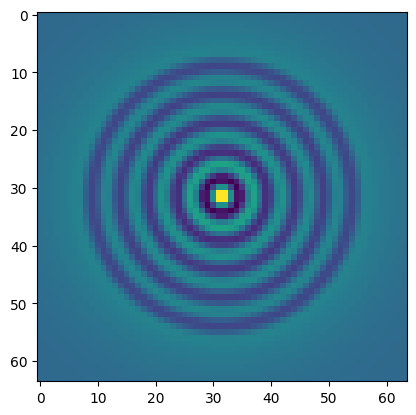

In [5]:
fiber.compute_modes_fields(grid)
plt.imshow(fiber._modes[:,:,1,-1])

Compute dataset

In [6]:
dset = SimulatedStepIndexSpeckleOutputDataset(fiber, grid, N_modes=fiber._N_modes_degen, length=dataset_settings['length'])
dset.compute_from_transfer_matrix(phases_dim=dataset_settings['phases_dim'])
# dset.compute_fourier_transforms(**fourier_settings)

Found 24 input variable weights below threshold 0.001 to delete.
Successfully deleted low weight input variables.
Computed TM row 1/232
Computed TM row 2/232
Computed TM row 3/232
Computed TM row 4/232
Computed TM row 5/232
Computed TM row 6/232
Computed TM row 7/232
Computed TM row 8/232
Computed TM row 9/232
Computed TM row 10/232
Computed TM row 11/232
Computed TM row 12/232
Computed TM row 13/232
Computed TM row 14/232
Computed TM row 15/232
Computed TM row 16/232
Computed TM row 17/232
Computed TM row 18/232
Computed TM row 19/232
Computed TM row 20/232
Computed TM row 21/232
Computed TM row 22/232
Computed TM row 23/232
Computed TM row 24/232
Computed TM row 25/232
Computed TM row 26/232
Computed TM row 27/232
Computed TM row 28/232
Computed TM row 29/232
Computed TM row 30/232
Computed TM row 31/232
Computed TM row 32/232
Computed TM row 33/232
Computed TM row 34/232
Computed TM row 35/232
Computed TM row 36/232
Computed TM row 37/232
Computed TM row 38/232
Computed TM row 39/23

In [ ]:
from copy import deepcopy

dsets = []
stds = sorted([7e-2, 5e-2, 4e-2, 3e-2, 2e-2, 1e-2, 5e-3, 0])

for std in stds:

    _dset = deepcopy(dset)
    _dset._coupling_matrix = (
        (np.real(dset._coupling_matrix) + std * np.random.randn(*dset._coupling_matrix.shape))
        + 1j * (np.imag(dset._coupling_matrix) + std * np.random.randn(*dset._coupling_matrix.shape))
    )

[3.05288617 2.84763346 3.08627068 4.35731303 3.37766301 4.18848447
 3.65636218 2.24984433 4.37785151 3.56177739]
[3.05288617 2.84763346 3.08627068 4.35731303 3.37766301 4.18848447
 3.65636218 2.24984433 4.37785151 3.56177739]


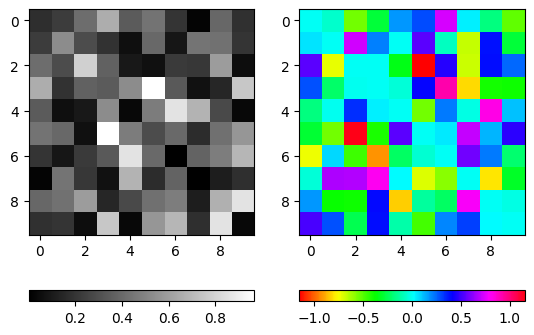

In [62]:
from waveoptics.plots.plots import complex_imshow
from scipy import linalg

def square_random_toeplitz(n, norm_intens: bool = True, complex: bool = True):
    vec = np.random.rand(n)

    if norm_intens:
        vec = np.sqrt(vec / np.sum(vec))
    matrix = linalg.toeplitz(vec, np.flip(vec))

    if complex:
        phi = 2 * np.pi * np.random.rand(n, n)
        if n > 1:
            triu_nodiag = np.triu(phi, k=1)
            triu = np.triu(phi)
            phi = np.angle(np.exp(1j * (triu - triu_nodiag.T)))
        matrix = matrix * np.exp(1j * phi)

    return matrix



def generate_hermitian_matrix(n):
    A = np.random.rand(n, n) + 1j * np.random.rand(n, n)
    H = (A + A.conj().T) / 2
    return H





# M0 = square_random_toeplitz(10, complex=True)
M0 = generate_hermitian_matrix(10)
print(np.sum(abs(M0) ** 2, 0))
print(np.sum(abs(M0) ** 2, 1))

plt.subplot(1, 2, 1)
plt.imshow(np.abs(M0) ** 2, cmap = 'gray')
plt.colorbar(location='bottom')

plt.subplot(1, 2, 2)
plt.imshow(np.angle(M0), cmap='hsv')
plt.colorbar(location='bottom')




In [71]:
import numpy as np

def generate_symmetric_doubly_stochastic_matrix(n):
    # Create a random symmetric matrix
    matrix = np.random.rand(n, n)
    matrix = (matrix + matrix.T) / 2
    
    for _ in range(10):  # Arbitrary number of iterations
        # Normalize rows and columns simultaneously
        row_col_sums = matrix.sum(axis=0) + matrix.sum(axis=1)
        matrix = matrix / row_col_sums
    
    return matrix

# Generate a 4x4 symmetric doubly stochastic matrix
result = generate_symmetric_doubly_stochastic_matrix(10)
# print(result)

# Verify row and column sums
print("Row sums:", result.sum(axis=1))
print("Column sums:", result.sum(axis=0))

Row sums: [0.51690702 0.5188552  0.49837588 0.47641759 0.51420029 0.54032109
 0.39354312 0.48845866 0.51083222 0.54216621]
Column sums: [0.48301237 0.48107924 0.50147688 0.52341897 0.4858216  0.45995323
 0.6062597  0.51159507 0.4894464  0.45801383]


In [ ]:
from copy import deepcopy

dsets = []
stds = sorted([7e-2, 5e-2, 4e-2, 3e-2, 2e-2, 1e-2, 5e-3, 0])

for std in stds:

    _dset = deepcopy(dset)
    _dset._coupling_matrix = (
        (np.real(dset._coupling_matrix) + std * np.random.randn(*dset._coupling_matrix.shape))
        + 1j * (np.imag(dset._coupling_matrix) + std * np.random.randn(*dset._coupling_matrix.shape))
    )

    # fig, axs = plt.subplots(1, 4, figsize=(15,5))
    # pl0 = axs[0].imshow(np.abs(dset._coupling_matrix))
    # pl1 = axs[1].imshow(np.abs(dset2._coupling_matrix))
    # pl2 = axs[2].imshow(np.angle(dset._coupling_matrix))
    # pl3 = axs[3].imshow(np.angle(dset2._coupling_matrix))
    # _ = [plt.colorbar(pl, ax=axs[i]) for i, pl in enumerate([pl0, pl1, pl2, pl3])]

    _dset.compute_from_transfer_matrix(phases_dim=dataset_settings['phases_dim'])
    dsets.append(_dset)
    # _dset.compute_fourier_transforms(**fourier_settings)

Found 24 input variable weights below threshold 0.001 to delete.
Successfully deleted low weight input variables.
Computed TM row 1/232
Computed TM row 2/232
Computed TM row 3/232
Computed TM row 4/232
Computed TM row 5/232
Computed TM row 6/232
Computed TM row 7/232
Computed TM row 8/232
Computed TM row 9/232
Computed TM row 10/232
Computed TM row 11/232
Computed TM row 12/232
Computed TM row 13/232
Computed TM row 14/232
Computed TM row 15/232
Computed TM row 16/232
Computed TM row 17/232
Computed TM row 18/232
Computed TM row 19/232
Computed TM row 20/232
Computed TM row 21/232
Computed TM row 22/232
Computed TM row 23/232
Computed TM row 24/232
Computed TM row 25/232
Computed TM row 26/232
Computed TM row 27/232
Computed TM row 28/232
Computed TM row 29/232
Computed TM row 30/232
Computed TM row 31/232
Computed TM row 32/232
Computed TM row 33/232
Computed TM row 34/232
Computed TM row 35/232
Computed TM row 36/232
Computed TM row 37/232
Computed TM row 38/232
Computed TM row 39/23

(4096, 232)


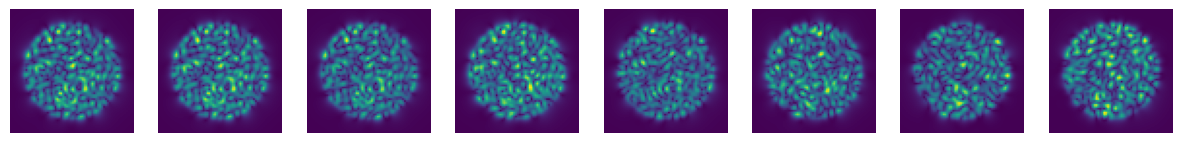

In [18]:
print(dset.reshaped_transfer_matrix.shape)

x = np.random.rand(dset.reshaped_transfer_matrix.shape[1]) * np.exp(1j * 2 * np.pi * np.random.rand(dset.reshaped_transfer_matrix.shape[1]))
y = []

plt.figure(figsize=(15, 5))
for i in range(len(dsets)):
    y = dsets[i].reshaped_transfer_matrix @ x
    y = np.reshape(y, [64, 64])

    plt.subplot(1, len(dsets), i + 1)
    plt.imshow(np.abs(y.reshape([64, 64])))
    # plt.colorbar(location='bottom')
    plt.axis('off')



### Dataset checking and export

Display a random draw from the dataset as a check

Export it if it looks ok

In [26]:
for i in range(len(dsets)):
    name = f"tm_{dsets[i]._phase_dims[0]:d}x{dsets[i]._phase_dims[1]:d}_s={stds[i]:1.1e}"
    dsets[i].export(name=name, **export_settings)

Dataset saved: .\tm_16x16_s=0.0e+00.mat
Dataset saved: .\tm_16x16_s=5.0e-03.mat
Dataset saved: .\tm_16x16_s=1.0e-02.mat
Dataset saved: .\tm_16x16_s=2.0e-02.mat
Dataset saved: .\tm_16x16_s=3.0e-02.mat
Dataset saved: .\tm_16x16_s=4.0e-02.mat
Dataset saved: .\tm_16x16_s=5.0e-02.mat
Dataset saved: .\tm_16x16_s=7.0e-02.mat


In [25]:
print(f"tm_{dsets[i]._phase_dims[0]:d}x{dsets[i]._phase_dims[1]:d}_s={stds[i]:1.1e}")

tm_16x16_s=7.0e-02


In [21]:
dset._phase_dims

(16, 16)